# Chapter 10 - Linear least squares
https://github.com/AllenDowney/ThinkStats2

## Reading

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import random

import thinkstats2
import thinkplot

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [4]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [5]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

In [6]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov


In [7]:
def LeastSquares(xs, ys):
    """Compute intercept and slope of least squares fit."""
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)
    
    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx
    
    return inter, slope

In [8]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.8303969733110526, 0.01745385147180276)

In [12]:
Mean(ages)

24.93612856826679

In [11]:
inter + slope * Mean(ages)

7.265628457623358

In [13]:
def FitLine(xs, inter, slope):
    """Evaluates the fitted line at the given xs."""
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [14]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

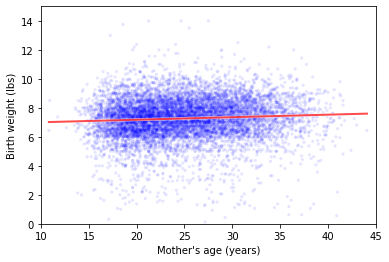

In [15]:
thinkplot.Scatter(ages, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Birth weight (lbs)',
                 axis=[10, 45, 0, 15],
                 legend=False)

Residuals:

In [16]:
def Residuals(xs, ys, inter, slope):
    """Compute the residuals."""
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [17]:
live['residual'] = Residuals(ages, weights, inter, slope)

In [18]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333312,
 17.74035928143719,
 20.506304824561838,
 23.455752212389893,
 26.435156146179903,
 29.411177432543294,
 32.30232530120497,
 35.240273631840736,
 38.10876470588231,
 40.91205882352941]

In [19]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [20]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

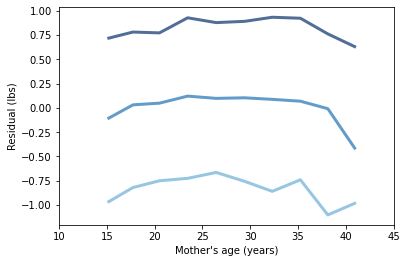

In [21]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Sampling distribution of `inter` and `slope`:

In [22]:
def SampleRows(df, nrows, replace=False):
    """
    Choose a sample of rows from a DataFrame.
    """
    
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    
    return sample

def ResampleRows(df):
    """
    Resamples rows from a DataFrame.
    """
    return SampleRows(df, len(df), replace=True)

In [23]:
def SamplingDistributions(live, iters=101):
    """
    Resamples the `live` DataFrame and returns lists of estimates for
    `inter` and `slope`.
    """
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)
        
    inters, slopes = zip(*t)
    return inters, slopes

In [24]:
inters, slopes = SamplingDistributions(live, iters=1001)

In [25]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [26]:
Summarize(inters)

mean, SE, CI 6.829070750637124 0.06926692806679738 (6.719766433846877, 6.941816706627373)


In [27]:
Summarize(slopes)

mean, SE, CI 0.017515226157941228 0.00275345536758321 (0.013056079615075497, 0.021781378871783243)


**Exercise:** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [32]:
def EstimateWeight(live, iters=1001):
    weight_estimates = []
    for _ in range(iters):
        sample = ResampleRows(live)
        weights = sample.totalwgt_lb
        weight_estimates.append(Mean(weights))
        
    return weight_estimates

In [33]:
weight_estimates = EstimateWeight(live)
Summarize(weight_estimates)

mean, SE, CI 7.265751191163341 0.014660544306072436 (7.242545364018588, 7.289645109537508)


Visualizing uncertainty:

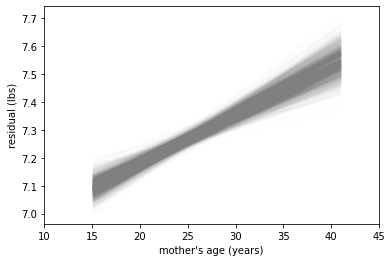

In [34]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="mother's age (years)", ylabel='residual (lbs)', xlim=[10, 45])

In [35]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter,slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)
        
    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

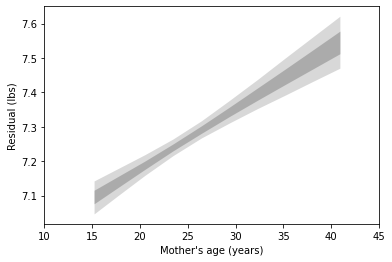

In [37]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Coefficient of determination:

In [38]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [39]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.004738115474710036

In [40]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.06883397035410911
R 0.06883397035410667


In [41]:
print('Std(ys)', Std(weights))
print('Std(res)', Std(res))

Std(ys) 1.4082155338406197
Std(res) 1.4048754287857834


In [43]:
class SlopeTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope
    
    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar
        
    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [44]:
ht = SlopeTest((ages, weights))
pvalue = ht.PValue()
pvalue

0.0

In [45]:
ht.actual, ht.MaxTestStat()

(0.01745385147180276, 0.007332556698450549)

We can also use resampling to estimate the sampling distribution of the slope.

In [46]:
sampling_cdf = thinkstats2.Cdf(slopes)

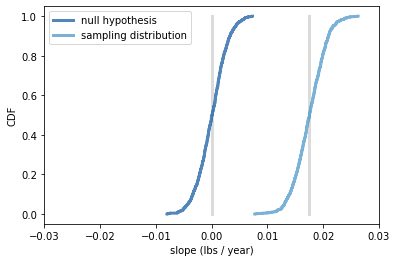

In [47]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='null hypothesis')

thinkplot.Cdf(sampling_cdf, label='sampling distribution')

thinkplot.Config(xlabel='slope (lbs / year)',
                   ylabel='CDF',
                   xlim=[-0.03, 0.03],
                   legend=True, loc='upper left')

In [48]:
pvalue = sampling_cdf[0]
pvalue

0

Resampling with weights:

In [49]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample =  df.loc[indices]
    return sample

In [50]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.34728652633326 0.01366590580902114 (7.323336191635318, 7.367579940252268)


In [51]:
# Without weights
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.266265144390352 0.014853563053788207 (7.243672549236557, 7.290557922106661)


## Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [52]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [59]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [60]:
# Estimate intercept and slope

inter, slope = LeastSquares(heights, log_weights)
inter, slope

(0.9930804163917826, 0.005281454169417984)

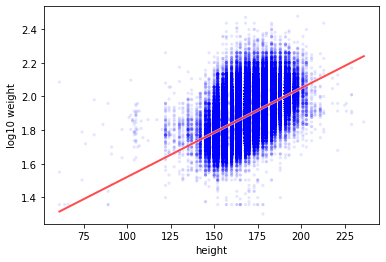

In [64]:
# Make a scatter plot with fitted line

fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, log_weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="height",
                 ylabel='log10 weight',
                 legend=False)

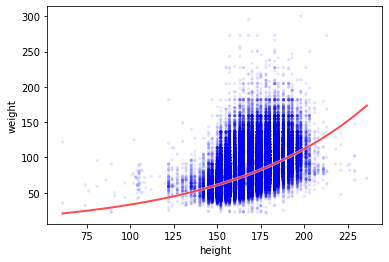

In [66]:
# Make a scatter plot with fitted line on linear scale

fit_xs, fit_ys = FitLine(heights, inter, slope)

thinkplot.Scatter(heights, weights, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, 10**fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, 10**fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="height",
                 ylabel='weight',
                 legend=False)

In [75]:
# Plot percentiles of the residuals
df['residual'] = Residuals(heights, log_weights, inter, slope)

In [99]:
bins = np.arange(125, 250, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

height_means = [group.htm3.mean() for _, group in groups][1:-1]
height_means

[126.78378378378379,
 130.8842105263158,
 135.78508771929825,
 141.43396226415095,
 146.33718778908417,
 151.52843968228584,
 156.3503419942746,
 161.67421045177736,
 166.56972746679975,
 171.40954232482787,
 176.54908086026674,
 181.57596142807944,
 186.32469990536435,
 191.7859712230216,
 196.6426561620709,
 201.73827160493826,
 206.64864864864865,
 211.51282051282053,
 218.0,
 221.0,
 227.88888888888889]

In [100]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

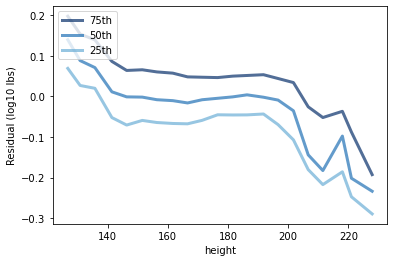

In [101]:
PlotPercentiles(height_means, cdfs)

thinkplot.Config(xlabel="height",
                 ylabel='Residual (log10 lbs)',
                 )

The residual is not constant with height but is mostly constant through 140-200.

In [80]:
# Compute correlation
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983571

In [77]:
# Compute coefficient of determination
r2 = CoefDetermination(log_weights, df['residual'])

In [78]:
r2

0.2827349431189321

In [81]:
rho**2, r2

(0.28273494311895436, 0.2827349431189321)

In [85]:
# Compute Std(ys), which is the RMSE of predictions that don't use height.

Std(log_weights)

0.10320725030004867

In [86]:
# Compute Std(res), the RMSE of predictions that do use height.
Std(df['residual'])

0.08740777080416114

In [87]:
(Std(log_weights) - Std(df['residual'])) / Std(log_weights)

0.1530849765879295

Height information reduces RMSE by 0.013 or about 15%.

In [89]:
# Use resampling to compute sampling distributions for `inter` and `slope`

def SamplingDistributions(df, iters=101):
    """
    Resamples the DataFrame and returns lists of estimates for
    `inter` and `slope`.
    """
    t = []
    for _ in range(iters):
        sample = ResampleRows(df)
        heights = sample.htm3
        weights = sample.wtkg2
        log_weights = np.log10(weights)
        estimates = LeastSquares(heights, log_weights)
        t.append(estimates)
        
    inters, slopes = zip(*t)
    return inters, slopes

In [90]:
inters, slopes = SamplingDistributions(df, iters=1001)

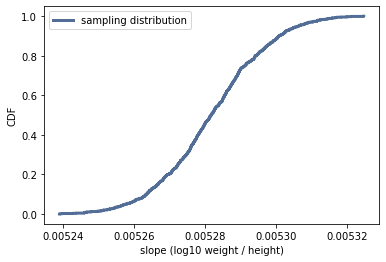

In [91]:
# Plot the sampling distribution of slope

sampling_cdf = thinkstats2.Cdf(slopes)

thinkplot.Cdf(sampling_cdf, label='sampling distribution')
thinkplot.Config(xlabel='slope (log10 weight / height)',
                   ylabel='CDF',
                   legend=True, loc='upper left')

In [93]:
# Compute the p-value of slope
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

ht = SlopeTest((heights, log_weights))
pvalue = ht.PValue()
pvalue

0.0

In [94]:
# Compute the 90% CI of slope
ci = sampling_cdf.Percentile(5), sampling_cdf.Percentile(95)
ci

(0.005257894177050162, 0.005306346003119236)

In [95]:
# Compute the mean of the sampling distribution
Mean(slopes)

0.00528193792657317

In [96]:
# Compute the standard deviation of the sampling distribution, which is the standard error
Std(slopes)

1.453557743048102e-05

In [97]:
# Resample rows without weights, compute mean height, and summarize results
iters = 100
estimates = [thinkstats2.ResampleRows(df).htm3.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 168.95451039835083 0.01513552940179084 (168.9291366034075, 168.97692960649974)


In [98]:
# Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.
iters = 100
estimates = [ResampleRowsWeighted(df, column='finalwt').htm3.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 170.4978524222398 0.015774858570675922 (170.46952747630309, 170.5194400654823)


This estimated mean height is 1.5 cm taller, much larger the sampling error.